In [3]:
import sys
sys.path.append("..")

In [4]:
import src.config

In [5]:
from src.datasets.loading import statcan, ookla

In [6]:
from notebooks.cluster import preparedata,best_k,AddCluster,DrawCluster2D
from notebooks.clusterTable import import_table

In [7]:
import numpy as np 
import pandas as pd
import geopandas as gp

In [8]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics
import matplotlib

In [9]:
import re

In [10]:
import matplotlib.pyplot as plt 

### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [11]:
# features_table=import_table(download=True)
features_table=pd.read_pickle("cluster_table")

In [17]:
# from os.path import exists
# exists("cluster_table.pkl")

False

In [35]:
print(features_table.loc[0,'lat'])

-79.12078857421875


In [12]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'lat','long',
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']
#calc_vars=list(features_table.columns[features_table.dtypes=="float64"])

In [13]:
calc_vars=['lat','lon','POP_DENSITY','das_area', 'tile_area', 'tile_frac',  'das_frac']
cat_vars=['CSDTYPE','PRNAME','SACTYPE']
col_subset = [pkey] + calc_vars+target_vars+cat_vars
features_table.loc[:,col_subset].set_index('quadkey')

,lat,lon,POP_DENSITY,das_area,tile_area,tile_frac,das_frac,avg_d_kbps,avg_u_kbps,CSDTYPE,PRNAME,SACTYPE
quadkey,,,,,,,,,,,,
302231302213222,-80.021667,43.646013,3.163016e+08,4.489387,0.205332,0.917314,0.041955,201908.916667,23286.833333,T,Ontario,1
302231302230013,-80.049133,43.638063,1.910586e+08,5.391016,0.205402,0.894827,0.034094,393118.031250,169457.281250,T,Ontario,1
302231302230022,-80.065613,43.630111,4.901126e+07,10.303754,0.205473,0.611219,0.012189,19284.750000,4310.750000,T,Ontario,1
302231302230023,-80.060120,43.630111,4.502452e+08,1.765704,0.205473,0.871430,0.101407,10499.585938,1387.898438,T,Ontario,1
302231302230030,-80.054626,43.634087,1.910586e+08,5.391016,0.205438,0.939933,0.035818,535.000000,889.000000,T,Ontario,1
...,...,...,...,...,...,...,...,...,...,...,...,...
303303002030011,-53.330383,46.737978,1.968805e+07,17.777278,0.179010,0.579748,0.005838,43155.000000,1901.000000,T,Newfoundland and Labrador / Terre-Neuve-et-Lab...,5
303303002032102,-53.324890,46.704086,1.968805e+07,17.777278,0.179287,0.533632,0.005382,1634.000000,690.000000,T,Newfoundland and Labrador / Terre-Neuve-et-Lab...,5
303303002122000,-53.258972,46.707853,1.256143e+08,1.194131,0.179256,0.574792,0.086285,37799.000000,12489.000000,T,Newfoundland and Labrador / Terre-Neuve-et-Lab...,7


In [20]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans,DBSCAN

In [14]:

# X=features_table.loc[:,(calc_vars+target_vars+cat_vars)].copy()
# X_NT=X.loc[X.loc[:,'PRNAME']=='Northwest Territories / Territoires du Nord-Ouest',:]
# label_encoder=LabelEncoder()
# for cat in cat_vars:
#     X[cat]=label_encoder.fit_transform(X[cat])
#     X[cat]=X[cat].astype(int)
# scaler = StandardScaler()
# X.loc[:,calc_vars+target_vars] = scaler.fit_transform(X.loc[:,calc_vars+target_vars])

X=preparedata(calc_vars,cat_vars,target_vars,df=features_table)


In [25]:
 k=best_k(20,X,'k-means++',500,10,42)
X=AddCluster(k=k,df=X)
# max_k = 20## iterations
# distortions = [] 
# for i in range(1, max_k+1):
#     if len(X) >= i:
#        model = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=42)
#        model.fit(X)
#        distortions.append(model.inertia_)## best k: the lowest derivative
# k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
#      in np.diff(distortions,2)]))## plot

# fig, ax = plt.subplots()
# ax.plot(range(1, len(distortions)+1), distortions)
# ax.axvline(k, ls='--', color="red", label="k = "+str(k))
# ax.set(title='The Elbow Method', xlabel='Number of clusters', 
#        ylabel="Distortion")
# ax.legend()
# ax.grid(True)
# plt.show()


/home/jovyan/notebooks/cluster.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["centroids"].iloc[i] = 1
/home/jovyan/notebooks/cluster.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["centroids"].iloc[i] = 1
/home/jovyan/notebooks/cluster.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["centroids"].iloc[i] = 1
/home/jovyan/notebooks/cluster.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of

NameError: name 'sns' is not defined

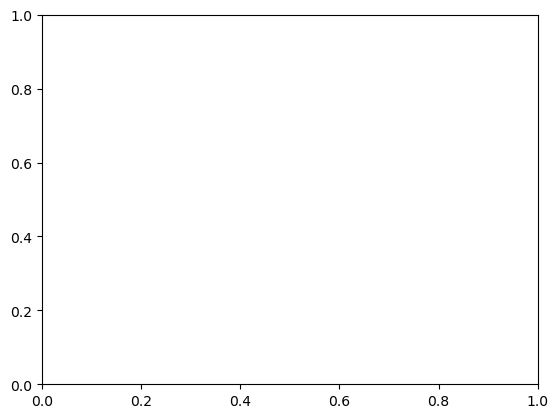

In [16]:
DrawCluster2D(X=X,k=k)

In [33]:
import scipy
k = 12
model = KMeans(n_clusters=k, init='random')
X.loc[:,"cluster"] = model.fit_predict(X)## find real centroids

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     X.drop("cluster", axis=1).values)
X["centroids"] = 0
for i in closest:
    X["centroids"].iloc[i] = 1## add clustering info to the original dataset

/tmp/ipykernel_182472/544271794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["centroids"].iloc[i] = 1## add clustering info to the original dataset
/tmp/ipykernel_182472/544271794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["centroids"].iloc[i] = 1## add clustering info to the original dataset
/tmp/ipykernel_182472/544271794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["centroids"].iloc[i] = 1## add clusteri

In [280]:
# Model = DBSCAN(eps=0.01, min_samples=5,).fit(X)
# class_predictions =Model.labels_

In [35]:
features_table[["cluster","centroids"]] = X[["cluster","centroids"]]

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


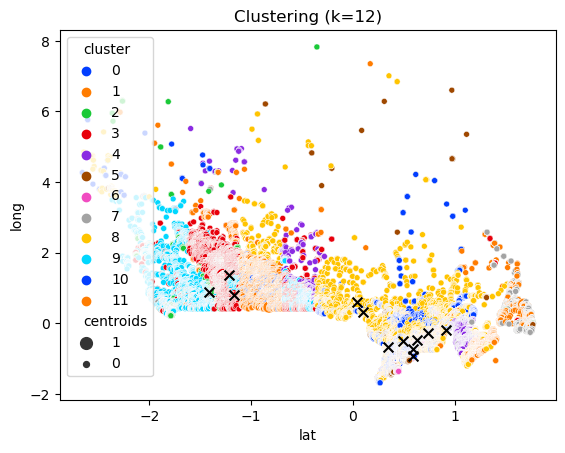

In [49]:
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(x="lat", y="long", data=X, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

/tmp/ipykernel_182472/3483803919.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax = features_table.plot(column='cluster', legend=True,figsize=(14,10),categorical=True,k=12,cmap=plt.cm.get_cmap('rainbow', 12),markersize=10,marker="O")


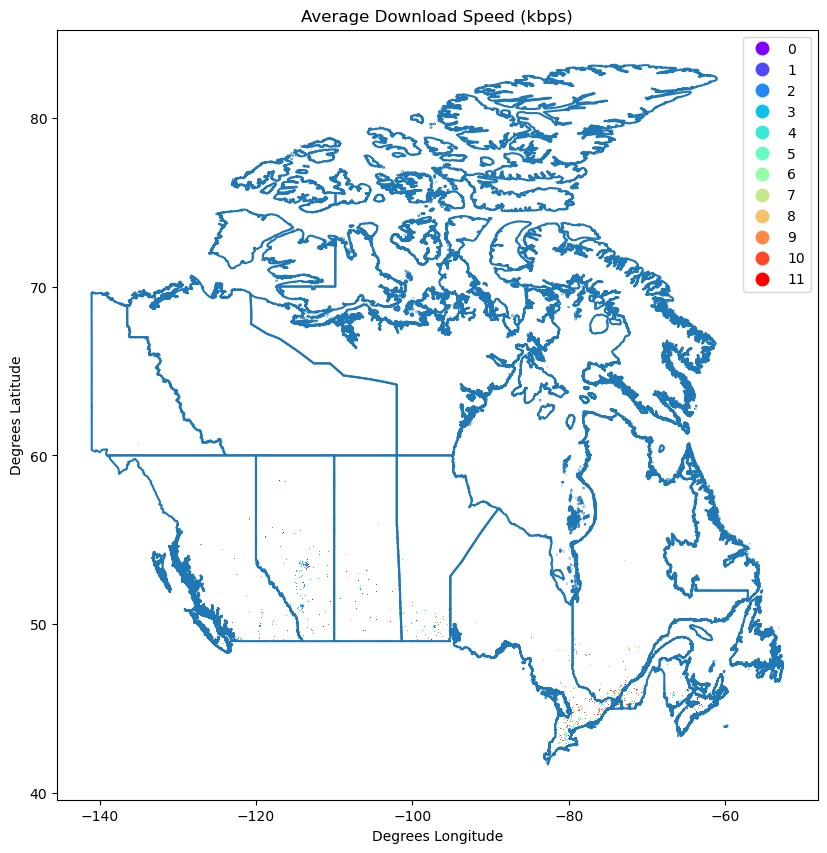

In [52]:
# features_table.to_crs('epsg:4326').plot(column='cluster', legend=True)
# plt.gcf().suptitle("Census Divisions Average Download Speeds (Mbps)")
# plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)");
ax = features_table.plot(column='cluster', legend=True,figsize=(14,10),categorical=True,k=12,cmap=plt.cm.get_cmap('rainbow', 12),markersize=10,marker="O")
ax.set(xlabel="Degrees Longitude", ylabel="Degrees Latitude")
ax.set_title("Average Download Speed (kbps)")
statcan.boundary("provinces").to_crs(features_table.crs).boundary.plot(ax=ax);

In [ ]:
map_ = folium.Map(locationvalue_countson, tiles="cartodbpositron",
                  zoom_start=11)
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""map_.get_root().html.add_child(folium.Element(legend_html))## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)## plot the map
map_

In [18]:
#Standard train/test where down and/or up speeds are the target/predicted continuous variable.
X_train, X_test, \
down_train, down_test, \
up_train, up_test = model_selection.train_test_split(
    features_table, features_table['avg_d_kbps'], features_table['avg_u_kbps']
)

In [20]:
#train the model
pipe.fit(X_train, down_train);

### Look at Some Analytics
The performance isn't very good, specifically if we consider the context of 
determining if individuals can access internet at the Federal 50/10 Mbps commitment level.

In [21]:
# how did it do on the training set
# speeds are in kbps
{"Mean Absolute Error":metrics.mean_absolute_error(pipe.predict(X_train), down_train),
"Median Absolute Error":metrics.median_absolute_error(pipe.predict(X_train), down_train),
"Mean Absolute Percentage Error":metrics.mean_absolute_percentage_error(pipe.predict(X_train), down_train)}

{'Mean Absolute Error': 62090.63217452738,
 'Median Absolute Error': 33804.55052241558,
 'Mean Absolute Percentage Error': 1.0966283565905748}

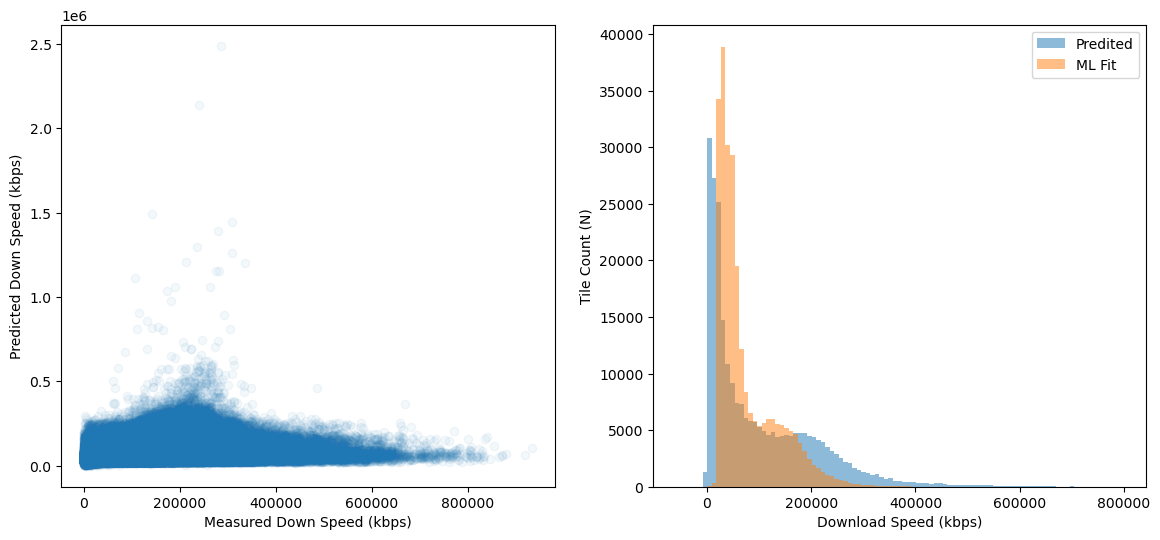

In [22]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].scatter(down_train, pipe.predict(X_train), alpha=0.05);
axs[0].set(xlabel="Measured Down Speed (kbps)", ylabel="Predicted Down Speed (kbps)");

bins = np.linspace(-60000,800000,100)
axs[1].hist(down_train,alpha=0.5, bins=bins,label='Predited')
axs[1].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='ML Fit');
axs[1].legend()
axs[1].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

<Axes: >

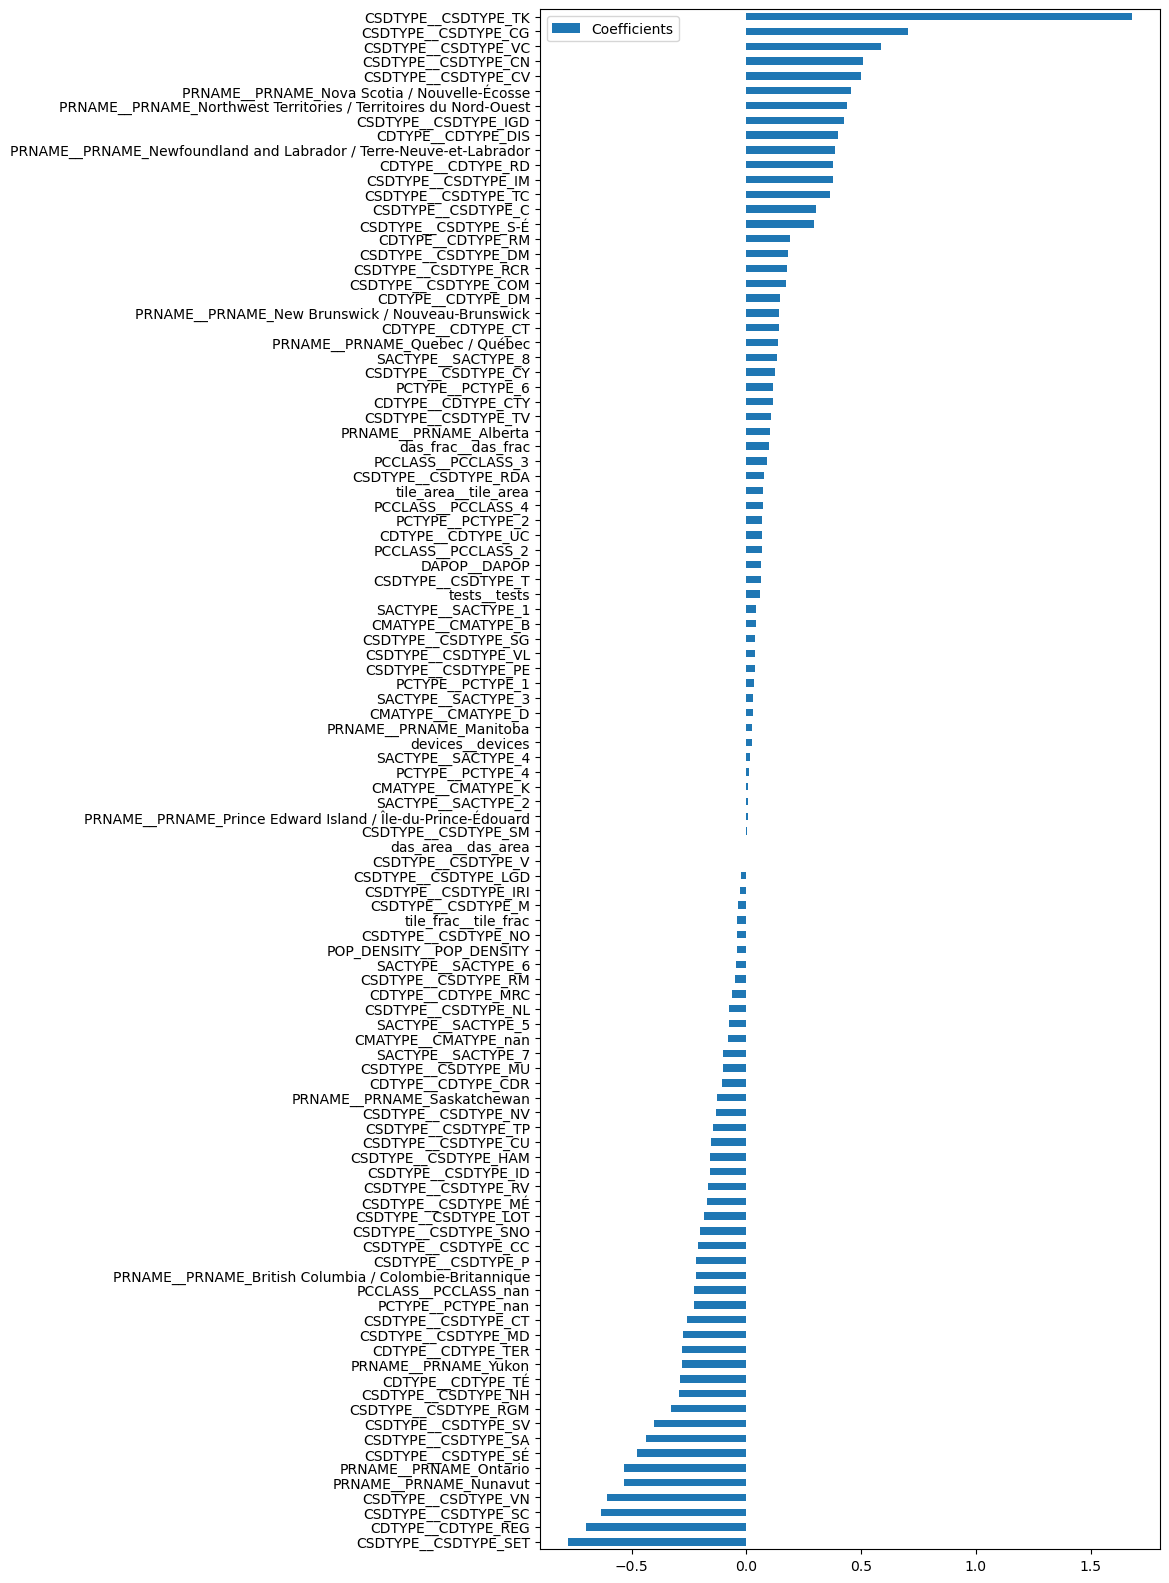

In [23]:
# What are the important coefficients.
coefs = pd.DataFrame(pipe[-1].regressor_.coef_,columns=['Coefficients'],index=pipe[:-1].get_feature_names_out())
coefs.sort_values(by='Coefficients').plot.barh(figsize=(8,20))